# Diagnosing why the weight for proximity predictor is consistently close to zero for all ages?
To try:
- Is the negative part of the predictor causing this?
    - Either threshold to zero or make repulsion radius 0 (are they the same thing?)

- Alternately could try to z-score nextStep score and all the predictors?

- It looks like the model is very good at fitting datapoints where nextStep score is small. Threshold deriveDF to large values of nextStep score and use that for inference?

In [11]:
from typing import List
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import os
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import seaborn as sns
import torch
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
import plotly.express as px
import collab.foraging.toolkit as ft

from collab.utils import find_repo_root
root = find_repo_root()
import logging
import time
import pickle

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
derivation_logger = logging.getLogger(__name__)

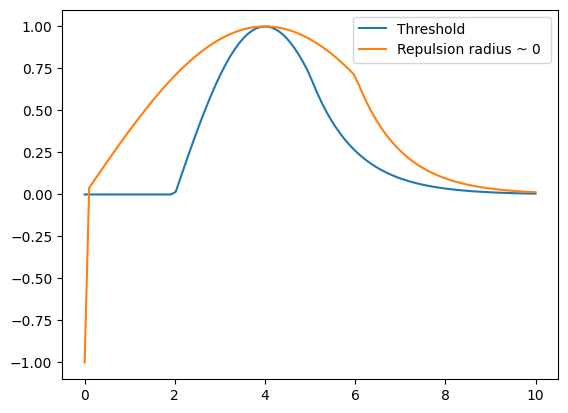

In [9]:
from collab.foraging.toolkit.proximity import _piecewise_proximity_function

x = np.linspace(0,10,100)
# plot two versions 

y1 = _piecewise_proximity_function(distance=x, repulsion_radius=2, optimal_distance=4, proximity_decay= 1)
y1[y1<0] = 0
plt.plot(x, y1, label="Threshold")
y2 = _piecewise_proximity_function(distance=x, repulsion_radius=0.0001, optimal_distance=4, proximity_decay= 1)
plt.plot(x, y2, label="Repulsion radius ~ 0 ")
plt.legend()

# Setting repulsion radius to zero has strange effects, so let's just threshold

## Load derivedDF

In [13]:
with open("derivedDF_saved.pkl","rb") as f :
    data = pickle.load(f)
    
exp_wise_derivedDF = data["exp_wise_derivedDF"]

In [14]:
# threshold proximity and rescale using eCDF

for df in exp_wise_derivedDF.values():
    df["proximity_thresh"] = df['proximity'].clip(lower=0)
    df["proximity_thresh_scaled"] = df["proximity_thresh"].rank(method="dense", pct=True)

# Run inference

# Model

In [15]:
class FishModel(pyro.nn.PyroModule):
    def __init__(self, predictors: dict, score: dict):
        super().__init__()

        self.predictors = predictors
        self.score = score
        self.n = len(score)

    def forward(self, predictors=None, score=None):
        if predictors is None:
            predictors = self.predictors

        size = len(next(iter(predictors.values())))

        weights = {}
        sigmas = {}
        for key in predictors.keys():
            weights[key] = pyro.sample(f"weight_{key}", dist.Normal(0.0, 1))
            sigmas[key] = pyro.sample(f"sigma_{key}", dist.Exponential(10.0))

        weights["b"] = pyro.sample("b", dist.Normal(0.5, 0.3))
        sigmas["bs"] = pyro.sample("bs", dist.Exponential(10.0))

        with pyro.plate("data", size):
            sigma = pyro.deterministic(
                "sigma",
                sum([predictors[key] * sigmas[key] for key in predictors.keys()])
                + sigmas["bs"],
            )

            sigma = torch.nn.functional.softplus(sigma) #since proximity predictor can be negative!

            assert torch.all(sigma > 0), "Sigma is not positive"

            mean = pyro.deterministic(
                "mean",
                sum([predictors[key] * weights[key] for key in predictors.keys()])
                + weights["b"],
            )

            observed_score = None
            if score is not None:
                observed_score = next(iter(score.values())) # gets the values without knowing the key ie score name

            pyro.sample("predicted_score", dist.Normal(mean, sigma), obs=observed_score)

# Helper functions for inference, model evaluation and visualization

In [16]:
def get_tensors_for_inference(
    derivedDF: pd.DataFrame, predictor_names: List[str], score_names: List[str]
):
    predictors = {}
    for name in predictor_names:
        predictors[name] = torch.tensor(derivedDF[name].values)

    scores = {}
    for name in score_names:
        scores[name] = torch.tensor(derivedDF[name].values)

    return predictors, scores

def run_svi_and_get_samples(
    model, predictors, score, num_svi_iters=600, verbose=False, num_samples=1000
):
    guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
    svi = SVI(model, guide, optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

    iterations = []
    losses = []

    logging.info(f"Starting SVI inference with {num_svi_iters} iterations.")
    start_time = time.time()
    pyro.clear_param_store()
    for i in range(num_svi_iters):
        elbo = svi.step(predictors=predictors, score=score)
        iterations.append(i)
        losses.append(elbo)
        if i % 200 == 0:
            logging.info("Step {}, elbo loss: {}".format(i, elbo))
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info("SVI inference completed in %.2f seconds.", elapsed_time)

    if verbose:
        fig = px.line(
            x=iterations, y=losses, title="ELBO loss", template="presentation"
        )
        labels = {"iterations": "iteration", "losses": "loss"}
        fig.update_xaxes(showgrid=False, title_text=labels["iterations"])
        fig.update_yaxes(showgrid=False, title_text=labels["losses"])
        fig.update_layout(width=700)
        fig.show()

    site_names = [f"weight_{key}" for key in predictors.keys()]
    predictive = Predictive(
        model=model,
        guide=guide,
        num_samples=num_samples,
        parallel=False,
        return_sites=site_names,
    )
    samples = predictive(predictors=predictors, score=score)
    return guide, samples

# getting score predictions is slower. only do that for a fraction of datapoints
# and fewer samples!
def evaluate_performance(
    model, guide, predictors, score, num_samples=100, sampling_fraction=1
):
    score_name = next(iter(score.keys()))

    sub_size = int(score[score_name].size(0) * sampling_fraction)
    randinds = torch.randint(0, score[score_name].size(0), (sub_size,))

    # downsample predictors and score
    score_sub = {score_name: score[score_name][randinds]}

    predictors_sub = {}
    for key, value in predictors.items():
        predictors_sub[key] = value[randinds]

    predictive = Predictive(
        model=model,
        guide=guide,
        num_samples=num_samples,
        parallel=False,
        return_sites=["predicted_score"],
    )
    samples = predictive(predictors=predictors_sub, score=None)

    predictions = samples["predicted_score"]

    predictions_mean = predictions.mean(dim=0)
    predictions_lower = predictions.quantile(0.025, dim=0)
    predictions_upper = predictions.quantile(0.975, dim=0)

    coverage = (
        (
            (predictions_lower <= score_sub[score_name])
            & (score_sub[score_name] <= predictions_upper)
        )
        .float()
        .mean()
    )

    observed_mean = score_sub[score_name].mean()

    residuals = score_sub[score_name] - predictions_mean

    mae = (torch.abs(residuals)).mean()

    rsquared = 1 - (
        torch.sum(residuals**2)
        / torch.sum((score_sub[score_name] - observed_mean) ** 2)
    )

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    heatmap = ax[0].hexbin(
        score_sub[score_name],
        predictions_mean,
        gridsize=100,
        cmap="Blues",
        norm=mpl.colors.LogNorm(),
    )
    fig.colorbar(heatmap, ax=ax[0])
    ax[0].set_title("Ratio of outcomes within 95% CI: {:.2f}".format(coverage.item()))
    ax[0].set_xlabel("observed values")
    ax[0].set_ylabel("mean predicted values")

    ax[1].hist(residuals.detach().numpy(), bins=50)
    ax[1].set_title(f"Residuals, MAE: {mae.item():.2f}, R²: {rsquared.item():.2f}")
    ax[1].set_xlabel("residuals")
    ax[1].set_ylabel("count")

    # print(f"Residuals, MAE: {mae.item():.2f}, R²: {rsquared.item():.2f}")

    plt.tight_layout(rect=(0, 0, 1, 0.96))
    sns.despine()
    fig.suptitle("Model evaluation", fontsize=16)
    plt.show()


def plot_density(predictors, scores, title):
    n_plots = len(predictors) * len(scores)
    #print(n_plots)
    ncols = 3
    nrows = np.ceil(n_plots / ncols).astype(int)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))

    plot_index = 0
    for i, predictor_name in enumerate(predictors.keys()):
        for j, score_name in enumerate(scores.keys()):

            if nrows > 1:
                r = plot_index // ncols
                c = plot_index % ncols
                #print([r,c])
                ax = axes[r, c]
            else:
                ax = axes[plot_index]

            heatmap = ax.hexbin(
                predictors[predictor_name],
                scores[score_name],
                gridsize=100,
                cmap="Blues",
                norm=mpl.colors.LogNorm(),
            )
            fig.colorbar(heatmap, ax=ax)
            ax.set_xlabel(f"{predictor_name} predictor")
            ax.set_ylabel(f"{score_name} score")
            # ax.set_aspect("equal")
            plot_index += 1

    # remove unused plots
    if n_plots % ncols:
        for ind in range(n_plots % ncols, ncols):
            if nrows > 1:
                fig.delaxes(axes[nrows-1,ind])
            else:
                fig.delaxes(axes[ind])

    fig.suptitle(title)
    fig.tight_layout()


def plot_distributions(derivedDF, column_names, title):
    fig, ax = plt.subplots(1, len(column_names), figsize=(3 * len(column_names), 3))

    for i, column in enumerate(column_names):
        ax[i].hist(derivedDF[column], bins=20, density=True, alpha=1)
        ax[i].set_yscale("log")
        ax[i].set_ylim([10**-3, 10**2])
        ax[i].set_xlabel(column)
        ax[i].set_ylabel("PDF")

    fig.suptitle(title)
    fig.tight_layout()

# Exclude velocityDiffusion, using raw values

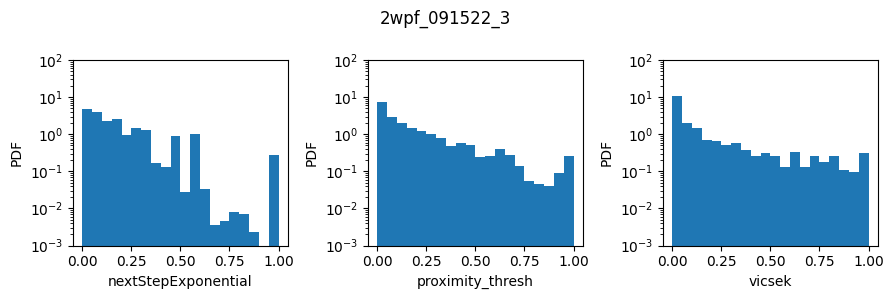

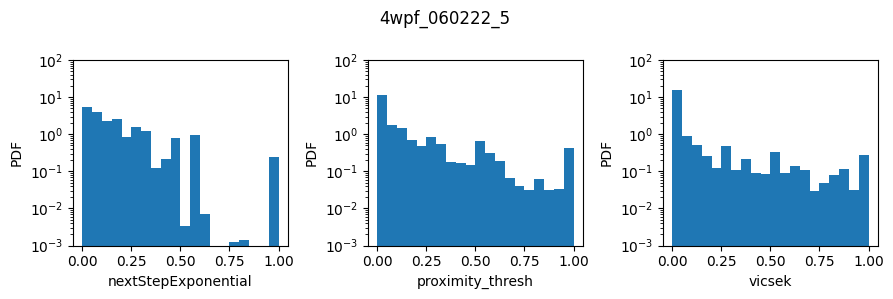

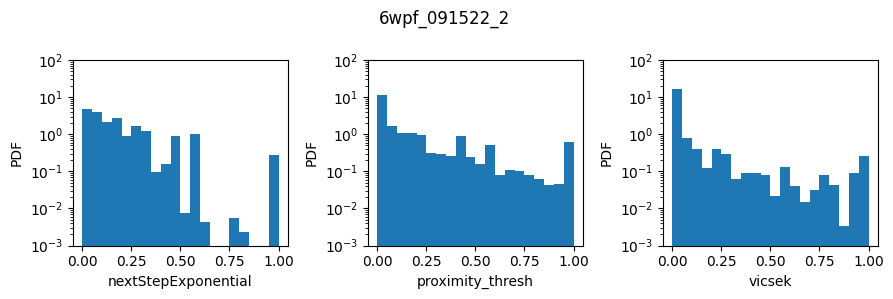

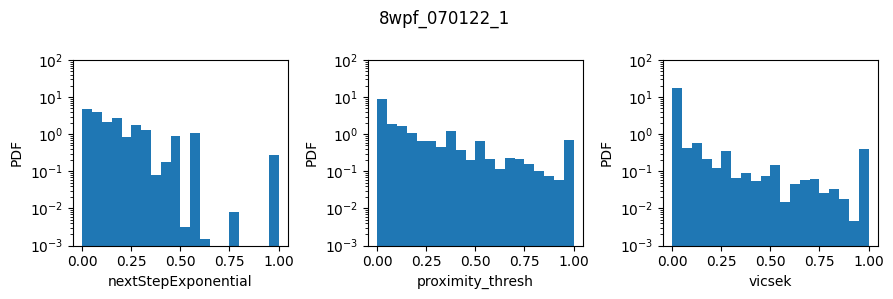

In [17]:
score_names = ["nextStepExponential"]
predictor_names = ["proximity_thresh", "vicsek"]

### Visualize the predictors and scores for each age
for exp in exp_wise_derivedDF.keys():
    plot_distributions(exp_wise_derivedDF[exp], score_names + predictor_names,title=exp)

### Perform inference and save coefficient samples for each age

In [18]:
coefficients_raw = {}

--------------------------------------------------
Starting inference : 2wpf_091522_3
--------------------------------------------------


2024-12-31 12:11:55,316 - Starting SVI inference with 1000 iterations.
2024-12-31 12:11:55,395 - Step 0, elbo loss: 23988.149378840913
2024-12-31 12:11:57,970 - Step 200, elbo loss: 20679.083729851318
2024-12-31 12:12:00,515 - Step 400, elbo loss: 20105.922655696537
2024-12-31 12:12:03,175 - Step 600, elbo loss: 19972.958016907825
2024-12-31 12:12:05,771 - Step 800, elbo loss: 19933.698517251265
2024-12-31 12:12:08,363 - SVI inference completed in 13.04 seconds.


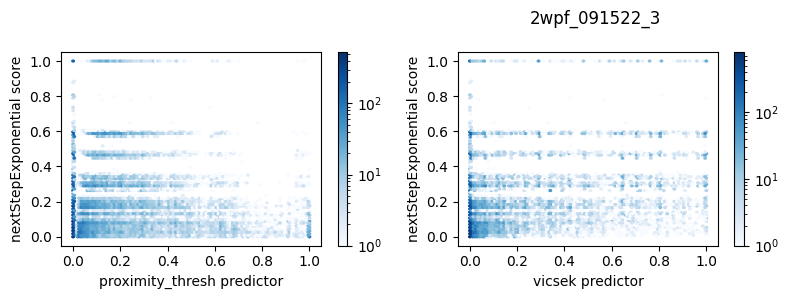

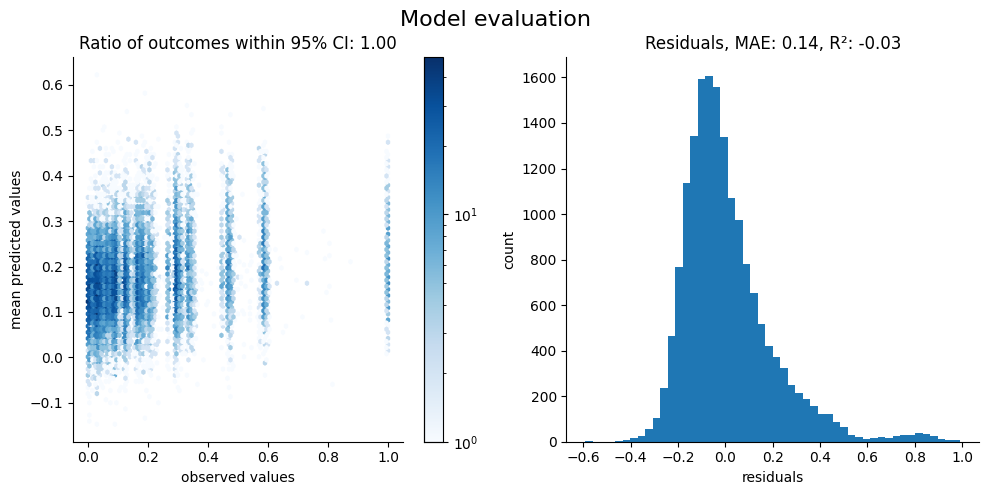

--------------------------------------------------
Starting inference : 4wpf_060222_5
--------------------------------------------------


2024-12-31 12:12:19,796 - Starting SVI inference with 1000 iterations.
2024-12-31 12:12:19,824 - Step 0, elbo loss: 72258.68453508726
2024-12-31 12:12:23,386 - Step 200, elbo loss: 58667.31827784011
2024-12-31 12:12:26,472 - Step 400, elbo loss: 57748.55422925018
2024-12-31 12:12:29,630 - Step 600, elbo loss: 57333.68002213089
2024-12-31 12:12:32,561 - Step 800, elbo loss: 57093.64589514552
2024-12-31 12:12:35,794 - SVI inference completed in 16.00 seconds.


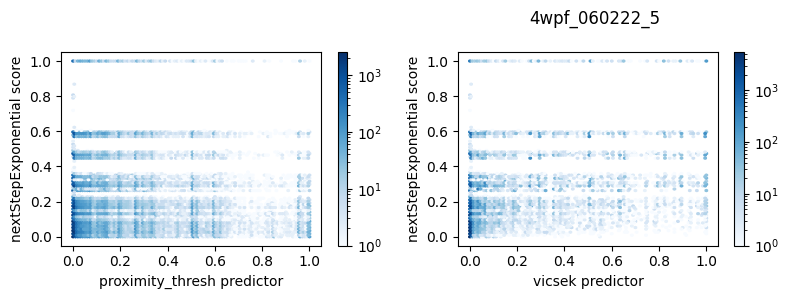

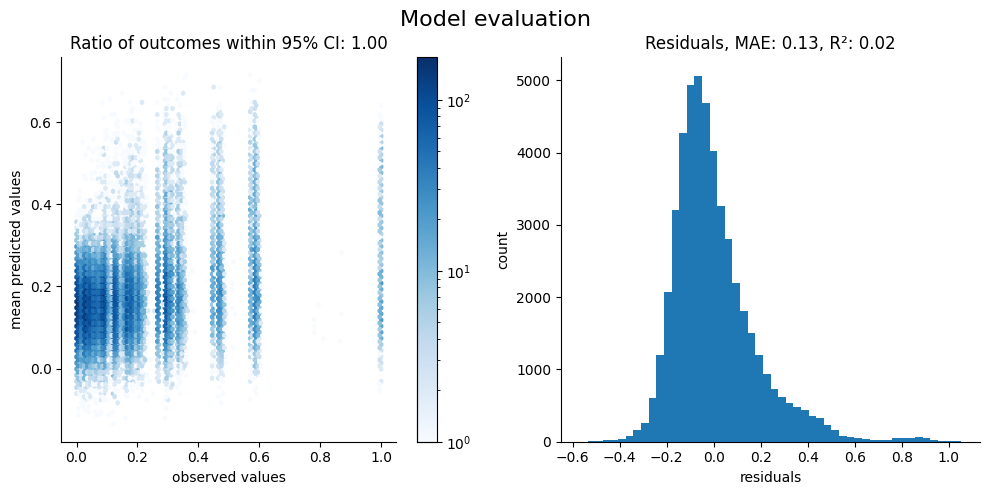

--------------------------------------------------
Starting inference : 6wpf_091522_2
--------------------------------------------------


2024-12-31 12:12:50,713 - Starting SVI inference with 1000 iterations.
2024-12-31 12:12:50,754 - Step 0, elbo loss: 113094.73645071933
2024-12-31 12:12:54,728 - Step 200, elbo loss: 100311.70992764301
2024-12-31 12:12:59,041 - Step 400, elbo loss: 98577.83550146529
2024-12-31 12:13:02,542 - Step 600, elbo loss: 97952.80705947538
2024-12-31 12:13:06,328 - Step 800, elbo loss: 97508.48288324913
2024-12-31 12:13:10,134 - SVI inference completed in 19.42 seconds.


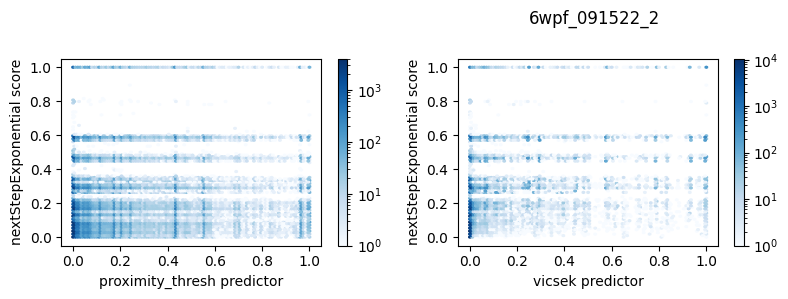

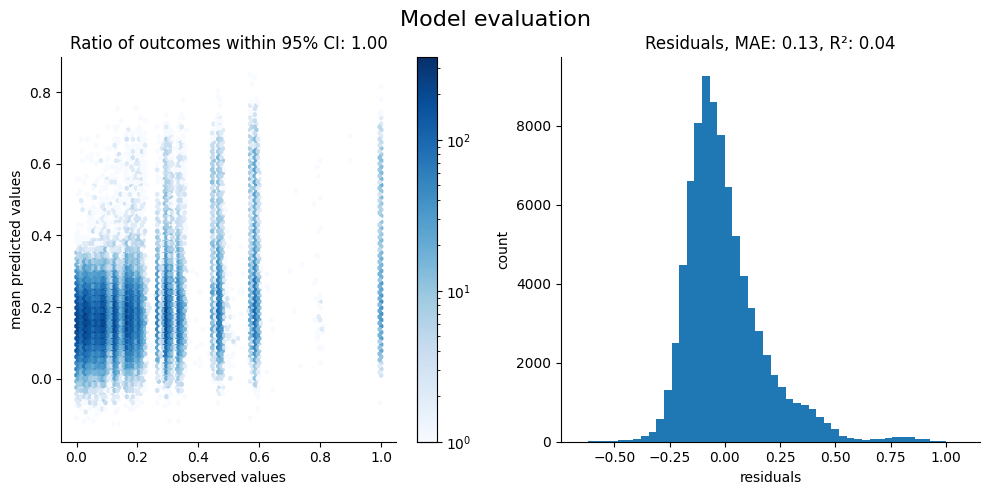

--------------------------------------------------
Starting inference : 8wpf_070122_1
--------------------------------------------------


2024-12-31 12:13:27,471 - Starting SVI inference with 1000 iterations.
2024-12-31 12:13:27,514 - Step 0, elbo loss: 186193.87134757428
2024-12-31 12:13:32,284 - Step 200, elbo loss: 152257.13752394327
2024-12-31 12:13:37,122 - Step 400, elbo loss: 148177.3891411535
2024-12-31 12:13:42,017 - Step 600, elbo loss: 147976.2641477025
2024-12-31 12:13:46,790 - Step 800, elbo loss: 146679.99649350235
2024-12-31 12:13:51,430 - SVI inference completed in 23.96 seconds.


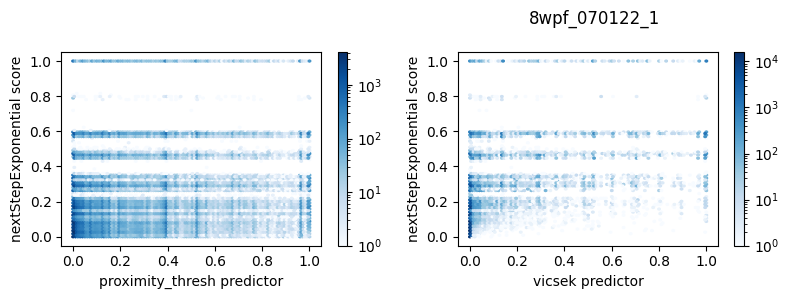

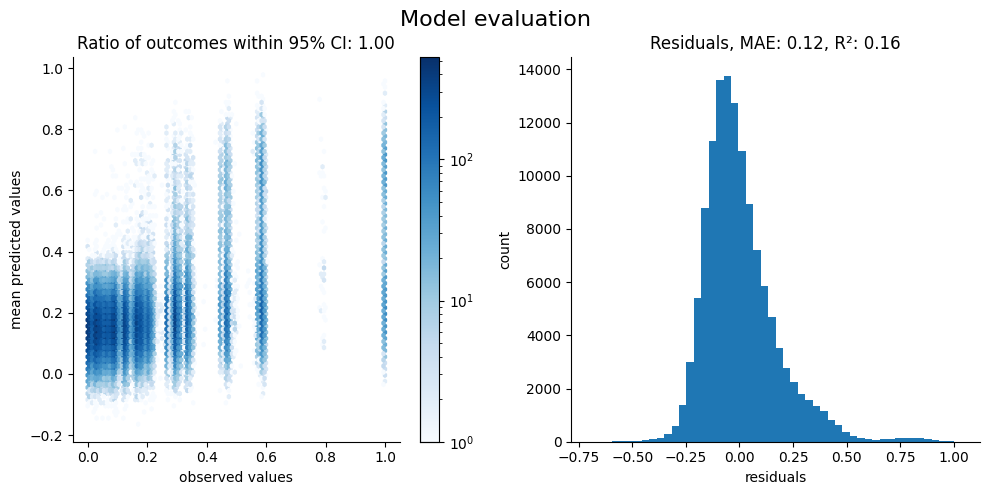

In [19]:
for exp in exp_wise_derivedDF.keys():
    print("-"*50)
    print(f"Starting inference : {exp}")
    print("-"*50)
    predictors, score = get_tensors_for_inference(
        exp_wise_derivedDF[exp], predictor_names=predictor_names, score_names=score_names
    )
    plot_density(predictors, score, exp)
    
    model = FishModel(predictors, score)
    guide, samples = run_svi_and_get_samples(
        model, predictors, score, verbose=True, num_samples=1000, num_svi_iters=1000
    )
    ft.plot_coefs(samples, f"{exp} - using raw predictor/score values", nbins=100)

    evaluate_performance(
        model, guide, predictors, score, num_samples=100, sampling_fraction=0.5
    )

    #save samples to dict
    coefficients_raw[exp] = samples

# Repeat for scaled scores

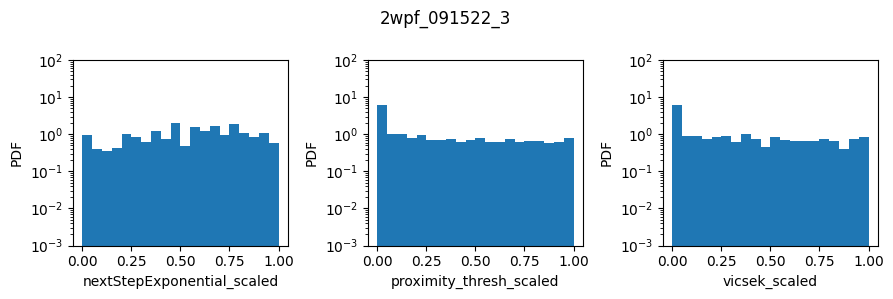

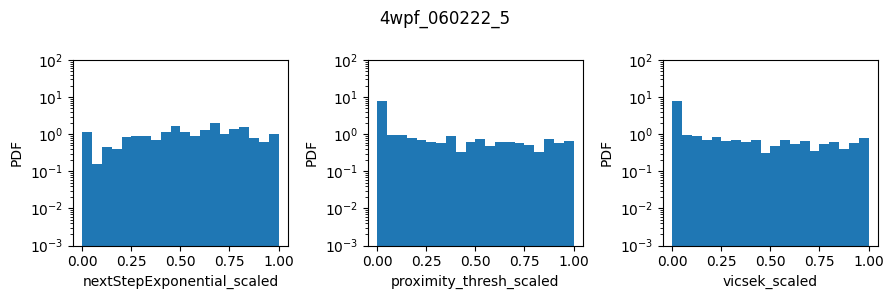

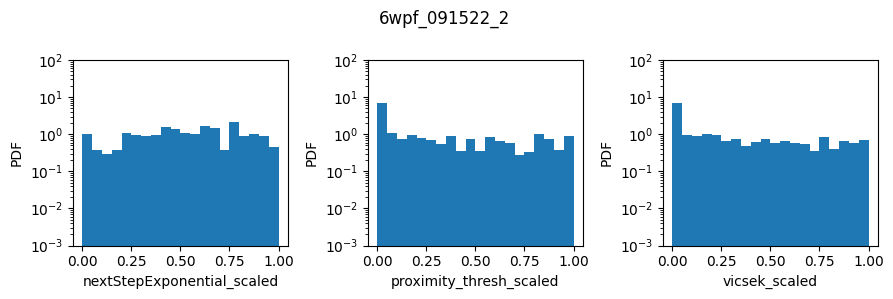

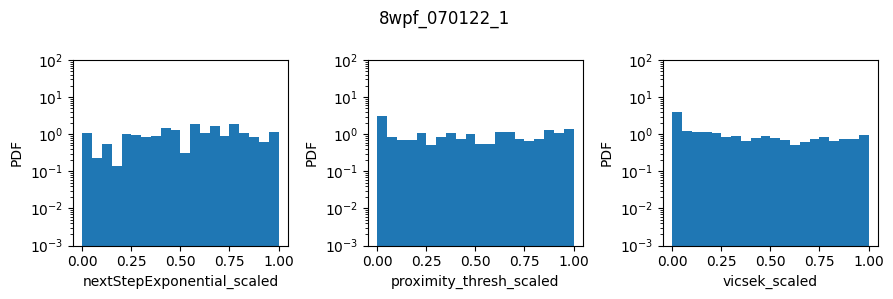

In [20]:
score_names = ["nextStepExponential_scaled"]
predictor_names = ["proximity_thresh_scaled", "vicsek_scaled"]

### Visualize the predictors and scores for each age
for exp in exp_wise_derivedDF.keys():
    plot_distributions(exp_wise_derivedDF[exp], score_names + predictor_names,title=exp)

--------------------------------------------------
Starting inference : 2wpf_091522_3
--------------------------------------------------


2024-12-31 12:16:20,353 - Starting SVI inference with 1000 iterations.
2024-12-31 12:16:20,413 - Step 0, elbo loss: 25118.009780694247
2024-12-31 12:16:24,443 - Step 200, elbo loss: 21838.81479800278
2024-12-31 12:16:29,537 - Step 400, elbo loss: 21263.303599146224
2024-12-31 12:16:33,986 - Step 600, elbo loss: 21112.58291479275
2024-12-31 12:16:38,286 - Step 800, elbo loss: 21099.107742233544
2024-12-31 12:16:41,716 - SVI inference completed in 21.36 seconds.


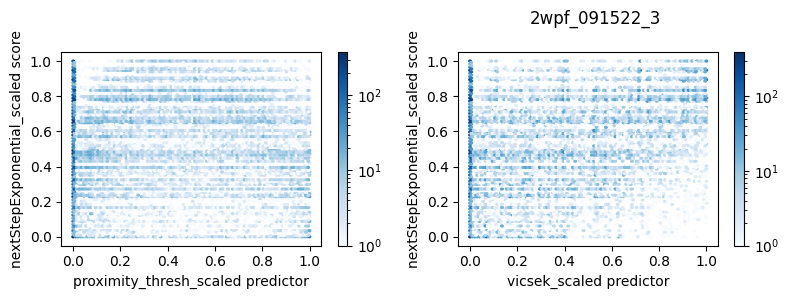

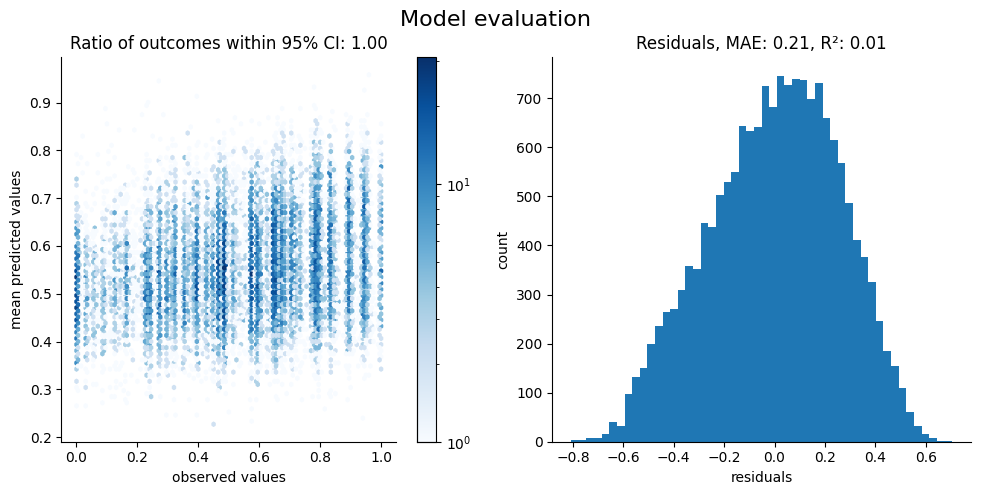

--------------------------------------------------
Starting inference : 4wpf_060222_5
--------------------------------------------------


2024-12-31 12:16:52,302 - Starting SVI inference with 1000 iterations.
2024-12-31 12:16:52,372 - Step 0, elbo loss: 71338.13051533082
2024-12-31 12:16:55,798 - Step 200, elbo loss: 62135.92513073404
2024-12-31 12:16:59,225 - Step 400, elbo loss: 60644.32189909469
2024-12-31 12:17:02,620 - Step 600, elbo loss: 60234.96952816949
2024-12-31 12:17:05,961 - Step 800, elbo loss: 60193.64583507211
2024-12-31 12:17:09,332 - SVI inference completed in 17.03 seconds.


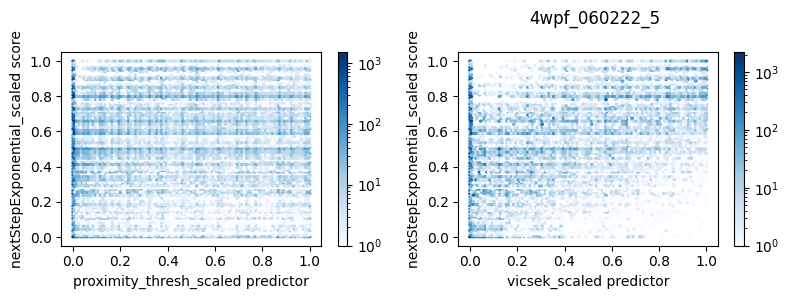

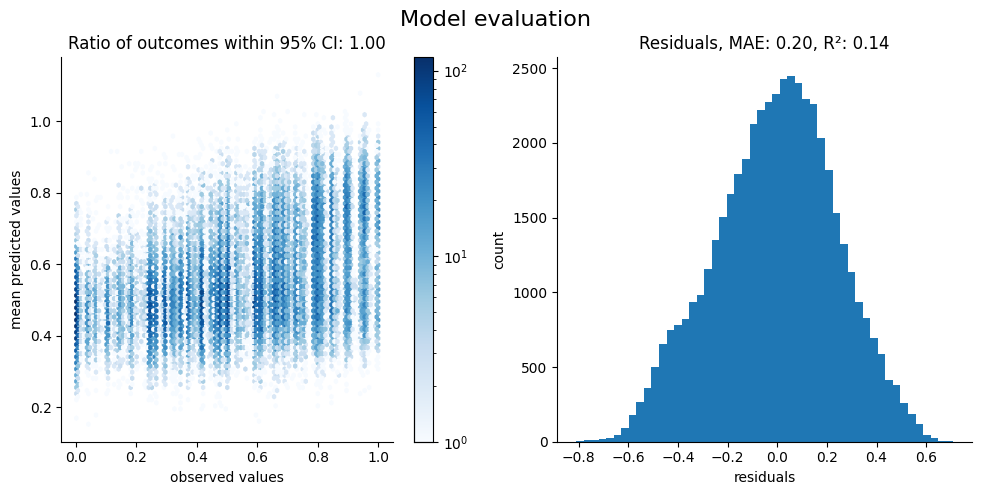

--------------------------------------------------
Starting inference : 6wpf_091522_2
--------------------------------------------------


2024-12-31 12:17:23,546 - Starting SVI inference with 1000 iterations.
2024-12-31 12:17:23,589 - Step 0, elbo loss: 130016.27655579252
2024-12-31 12:17:27,396 - Step 200, elbo loss: 106263.12078331542
2024-12-31 12:17:31,363 - Step 400, elbo loss: 103581.6713556836
2024-12-31 12:17:35,110 - Step 600, elbo loss: 102075.76276272477
2024-12-31 12:17:38,910 - Step 800, elbo loss: 101896.80584833806
2024-12-31 12:17:42,514 - SVI inference completed in 18.97 seconds.


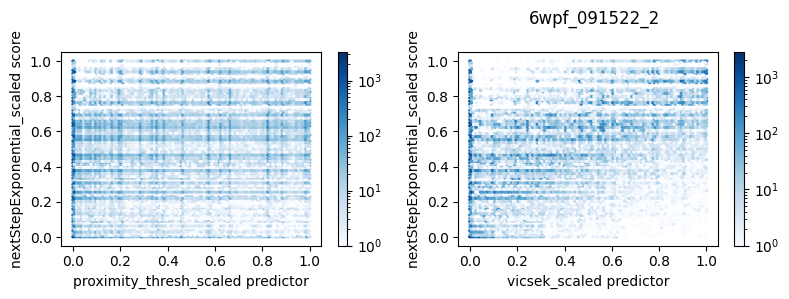

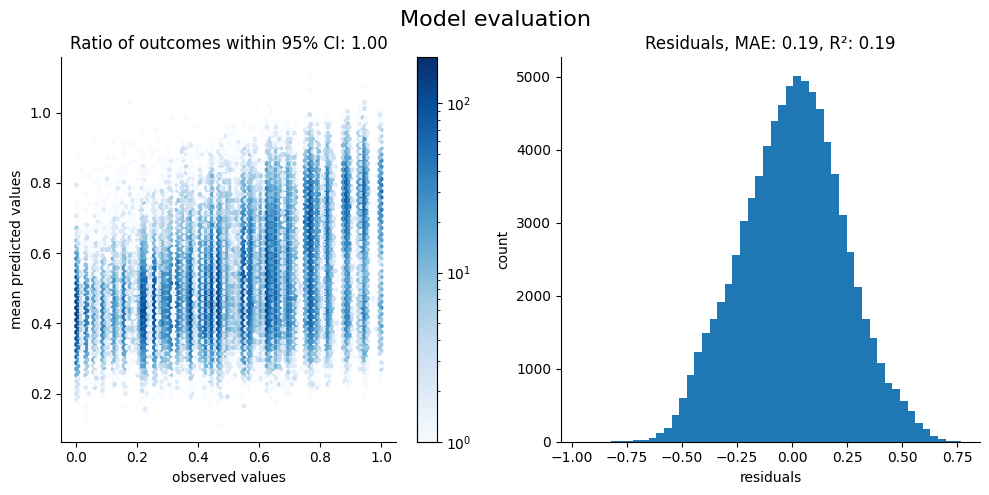

--------------------------------------------------
Starting inference : 8wpf_070122_1
--------------------------------------------------


2024-12-31 12:17:58,905 - Starting SVI inference with 1000 iterations.
2024-12-31 12:17:58,963 - Step 0, elbo loss: 187852.66112194554
2024-12-31 12:18:03,871 - Step 200, elbo loss: 157879.42757352436
2024-12-31 12:18:08,803 - Step 400, elbo loss: 153339.68498614134
2024-12-31 12:18:14,118 - Step 600, elbo loss: 151772.2702076579
2024-12-31 12:18:19,243 - Step 800, elbo loss: 151027.5117057453
2024-12-31 12:18:24,374 - SVI inference completed in 25.47 seconds.


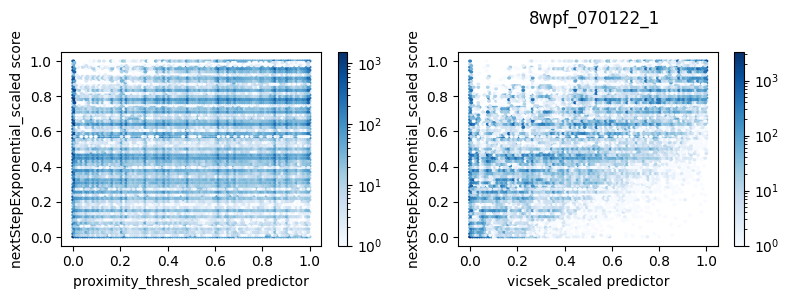

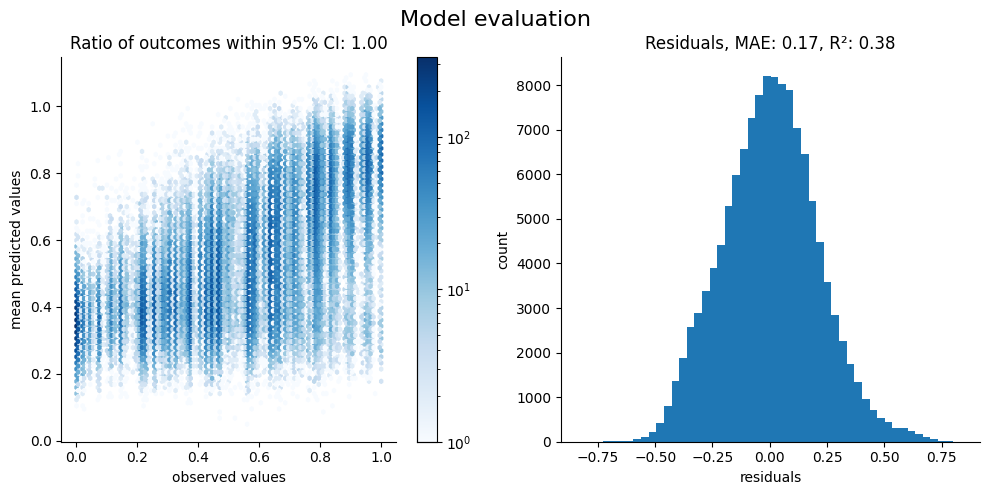

In [21]:
coefficients_scaled = {}

for exp in exp_wise_derivedDF.keys():
    print("-"*50)
    print(f"Starting inference : {exp}")
    print("-"*50)
    predictors, score = get_tensors_for_inference(
        exp_wise_derivedDF[exp], predictor_names=predictor_names, score_names=score_names
    )
    plot_density(predictors, score, exp)
    
    model = FishModel(predictors, score)
    guide, samples = run_svi_and_get_samples(
        model, predictors, score, verbose=True, num_samples=1000, num_svi_iters=1000
    )
    ft.plot_coefs(samples, f"{exp} - using scaled predictor/score values", nbins=100)

    evaluate_performance(
        model, guide, predictors, score, num_samples=100, sampling_fraction=0.5
    )

    #save samples to dict
    coefficients_scaled[exp] = samples

In [27]:
def plot_comparative_results(samples,title):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.axhline(0,linestyle="--",color='k')
    ax.axvline(0,linestyle="--",color='k')

    for exp,sample in samples.items():
        try:
            p = sample["weight_proximity_thresh"]
            v = sample["weight_vicsek"]
        except KeyError:
            p = sample["weight_proximity_thresh_scaled"]
            v = sample["weight_vicsek_scaled"]

        ax.scatter(p,v,alpha=0.3,label=exp,s=5)

    ax.set_xlabel("proximity coefficient")
    ax.set_ylabel("vicsek coefficient")
    ax.set_xlim([-0.2,0.7])
    ax.set_ylim([-0.2,0.7])
    ax.legend()
    fig.suptitle(title)

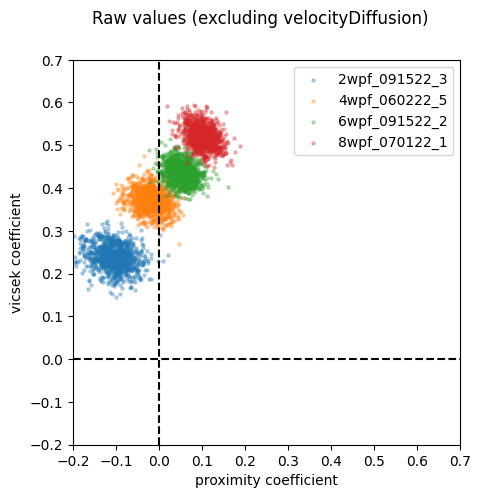

In [28]:
plot_comparative_results(coefficients_raw,"Raw values (excluding velocityDiffusion)")

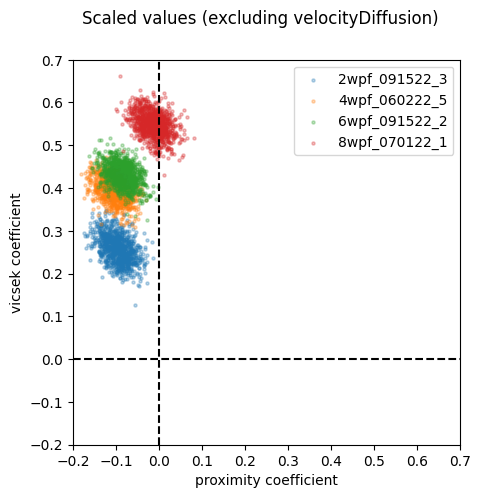

In [29]:
plot_comparative_results(coefficients_scaled,"Scaled values (excluding velocityDiffusion)")